# K-Means Clustering/Segmentation

In [1]:
import pandas as pd

In [2]:
rfm_df = pd.read_parquet('../data/rfm/rfm_retail_data.parquet')

In [3]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,CustomerLifespan,AvgGap,MedianGap,MaxGap,FavMonth,PctHighSeason,PctWeekend
0,12346.0,325,3,77352.96,321,122.250000,118.0,203.0,6,0.000000,0.000000
1,12347.0,1,8,4921.53,402,61.456044,53.0,90.0,10,0.391892,0.180180
2,12348.0,74,5,1658.40,362,77.814815,80.0,173.0,9,0.456522,0.043478
3,12349.0,18,3,3678.69,570,299.857143,389.0,389.0,11,0.732558,0.000000
4,12350.0,309,1,294.40,0,NaN,NaN,NaN,2,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5848,18283.0,3,22,2658.95,654,33.327009,20.0,143.0,11,0.376068,0.105769
5849,18284.0,431,1,461.68,0,NaN,NaN,NaN,10,1.000000,0.000000
5850,18285.0,660,1,427.00,0,NaN,NaN,NaN,2,0.000000,0.000000
5851,18286.0,476,2,1296.43,247,247.000000,247.0,247.0,8,0.000000,0.000000


## Normalization before clustering

In [4]:
rfm_df.isnull().sum()

Customer ID            0
Recency                0
Frequency              0
Monetary               0
CustomerLifespan       0
AvgGap              1619
MedianGap           1619
MaxGap              1619
FavMonth               0
PctHighSeason          0
PctWeekend             0
dtype: int64

In [5]:
rfm_df['AvgGap'] = rfm_df['AvgGap'].fillna(rfm_df['AvgGap'].max())

In [6]:
rfm_df["Recency_score"] = pd.qcut(rfm_df['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm_df["Frequency_score"] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])

In [7]:
rfm_df["rf_segment"] = rfm_df['Recency_score'].astype(str) + rfm_df['Frequency_score'].astype(str)

In [8]:
segment_map = {
    r'[1-2][1-2]' : 'Hibernating',
    r'[1-2][3-4]' : 'At-Risk',
    r'[1-2]5' : "Can\'t Loose",
    r'3[1-2]' : 'About to Slip',
    r'33' : 'Need Attention',
    r'[3-4][4-5]' : 'Loyal Customers',
    r'41' : 'Promising',
    r'51' : 'New Customers',
    r'[4-5][2-3]' : 'Potential Loyalists',
    r'5[4-5]' : 'Champions',
}

In [9]:
rfm_df['rf_segment'] = rfm_df['rf_segment'].replace(segment_map, regex = True)

In [10]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,CustomerLifespan,AvgGap,MedianGap,MaxGap,FavMonth,PctHighSeason,PctWeekend,Recency_score,Frequency_score,rf_segment
0,12346.0,325,3,77352.96,321,122.250000,118.0,203.0,6,0.000000,0.000000,2,3,At-Risk
1,12347.0,1,8,4921.53,402,61.456044,53.0,90.0,10,0.391892,0.180180,5,4,Champions
2,12348.0,74,5,1658.40,362,77.814815,80.0,173.0,9,0.456522,0.043478,3,4,Loyal Customers
3,12349.0,18,3,3678.69,570,299.857143,389.0,389.0,11,0.732558,0.000000,5,3,Potential Loyalists
4,12350.0,309,1,294.40,0,714.000000,NaN,NaN,2,0.000000,0.000000,2,1,Hibernating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848,18283.0,3,22,2658.95,654,33.327009,20.0,143.0,11,0.376068,0.105769,5,5,Champions
5849,18284.0,431,1,461.68,0,714.000000,NaN,NaN,10,1.000000,0.000000,1,2,Hibernating
5850,18285.0,660,1,427.00,0,714.000000,NaN,NaN,2,0.000000,0.000000,1,2,Hibernating
5851,18286.0,476,2,1296.43,247,247.000000,247.0,247.0,8,0.000000,0.000000,1,3,At-Risk


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

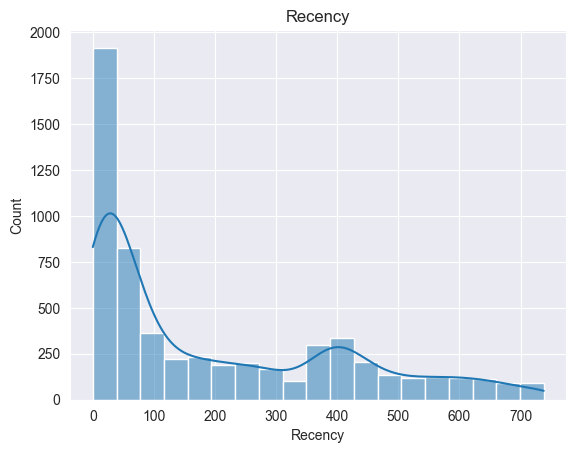

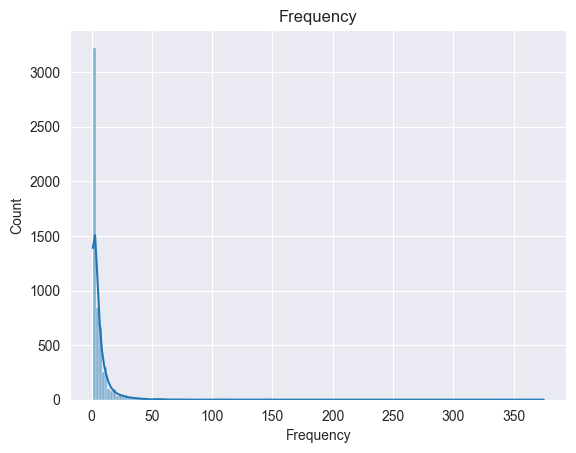

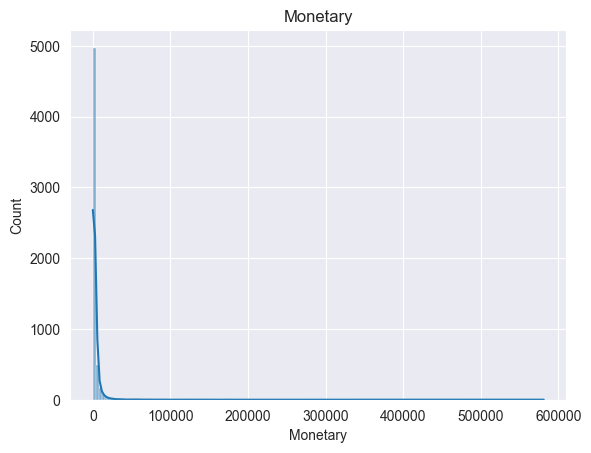

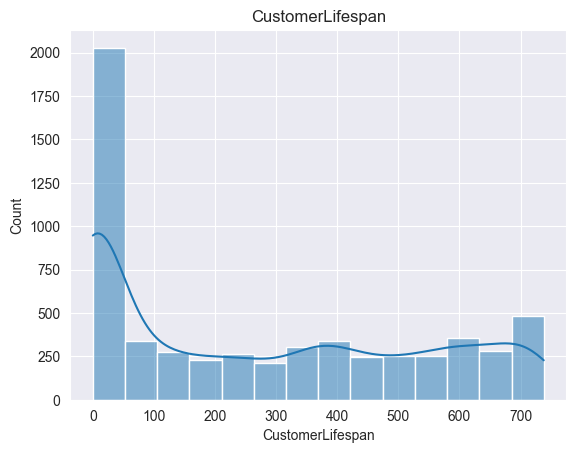

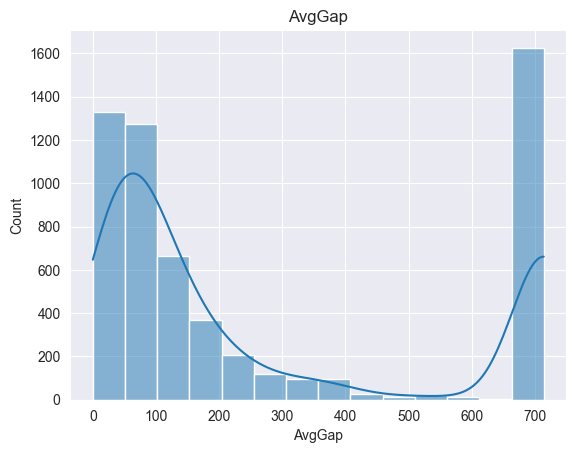

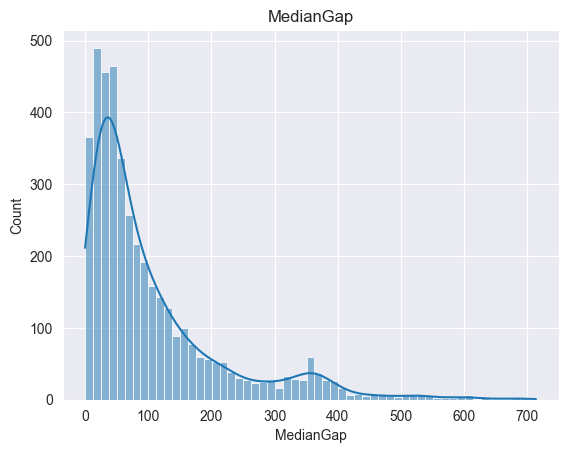

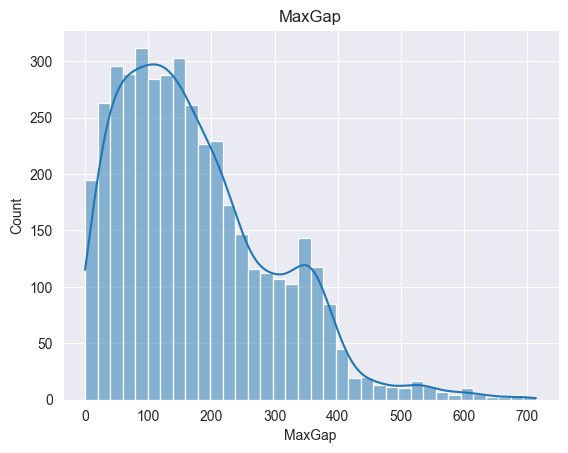

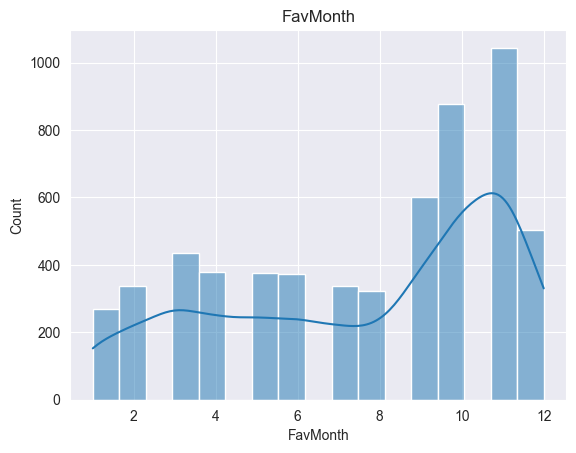

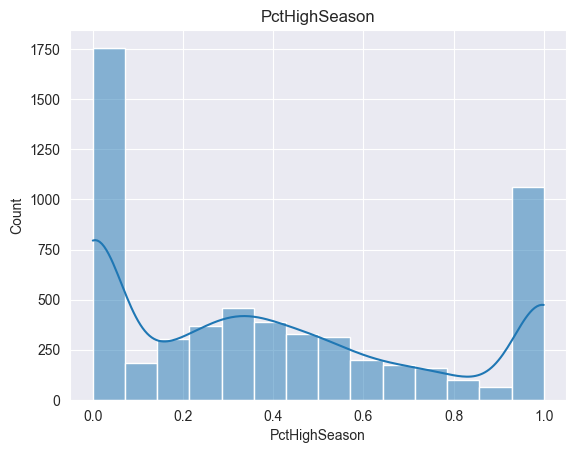

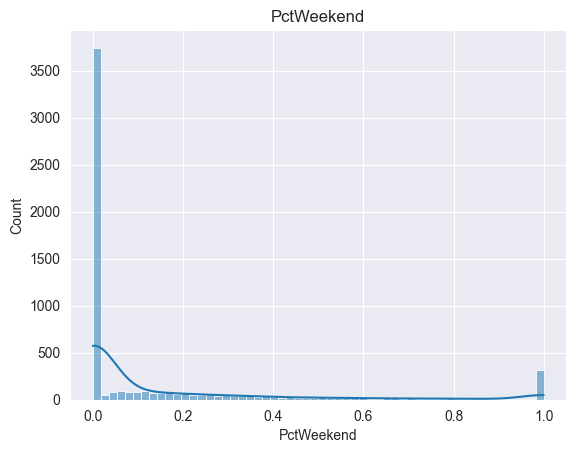

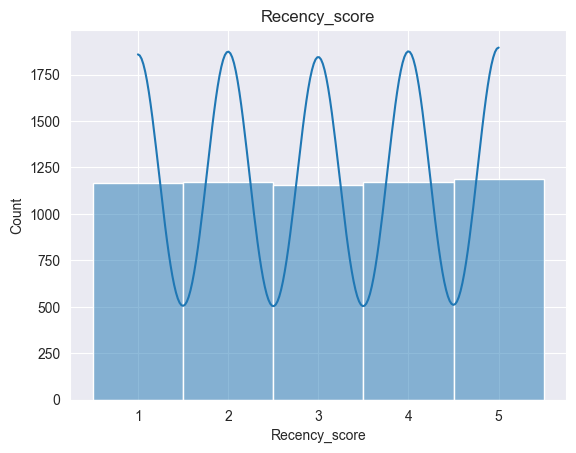

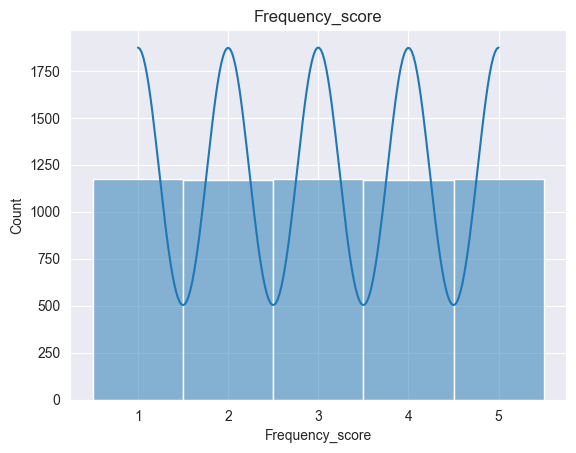

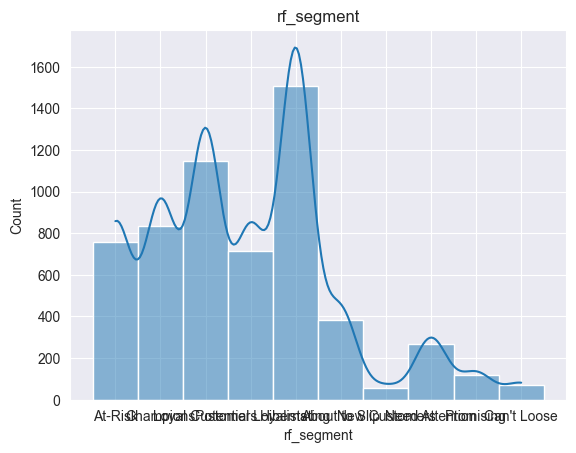

In [12]:
for col in rfm_df.columns[1:]:
    sns.histplot(rfm_df[col], kde=True)
    plt.title(col)
    plt.show()

The RFM variables show strong right-skewedness, with a concentration of customers at low values and a long tail of highly active customers. In order to reduce skewness and to limit the influence of outliers on the Euclidean distances of KMeans, we applied a log1p transformation followed by a RobustScaler.

We observes also `PctHighSeason` and `PctWeekend` columns have the same distribution : big peak at 0%, a second smaller peak at 100% and the rest uniformly distributed in between.

In [13]:
from sklearn.preprocessing import RobustScaler
import numpy as np

In [14]:
rfm_scaled_df = np.log1p(rfm_df[['Recency', 'Frequency', 'Monetary']])
scaler = RobustScaler()
rfm_scaled_df = scaler.fit_transform(rfm_scaled_df)

In [15]:
rfm_scaled_df

array([[ 0.45353973,  0.        ,  2.39413914],
       [-1.42008533,  0.5849625 ,  0.92949355],
       [-0.08695046,  0.29248125,  0.35132451],
       ...,
       [ 0.71354148, -0.5       , -0.36919613],
       [ 0.59354218, -0.20751875,  0.22048504],
       [-0.29156889,  0.5       ,  0.84305941]], shape=(5853, 3))

<Axes: >

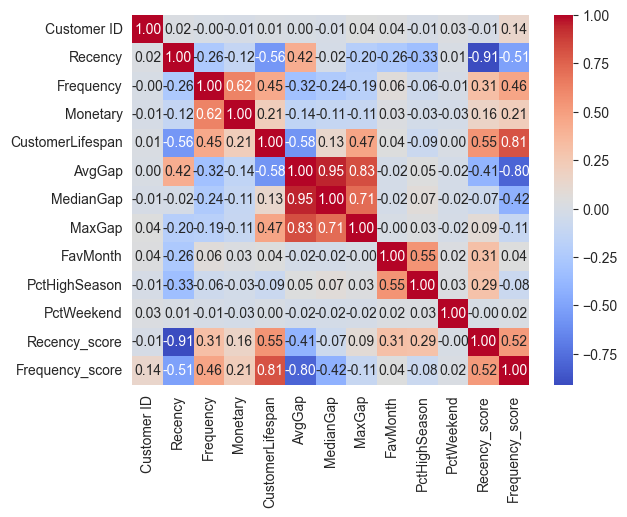

In [16]:
sns.heatmap(rfm_df.drop(columns='rf_segment').corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [17]:
X = rfm_scaled_df

We delete these columns because:
- `Customer ID` is just an identifier and does not contain useful information for clustering.
- `PctHighSeason` and `PctWeekend` have a lot of customers with 0% and 100% values, which can distort the clustering results.
- `FavMonth` is a categorical variable representing the favorite month of purchase, which is not suitable for K-Means clustering that relies on numerical distance metrics.
- `MedianGap` and `MaxGap` are highly correlated with `AvgGap`, so we can keep only one of them to reduce redundancy.

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=20)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))

In [20]:
silhouette

[0.43847744463341903,
 0.3446663197671,
 0.35789119040405,
 0.33554335071017755,
 0.3200305271076863,
 0.3228905507202012,
 0.29410779912457297,
 0.29100111400507295]

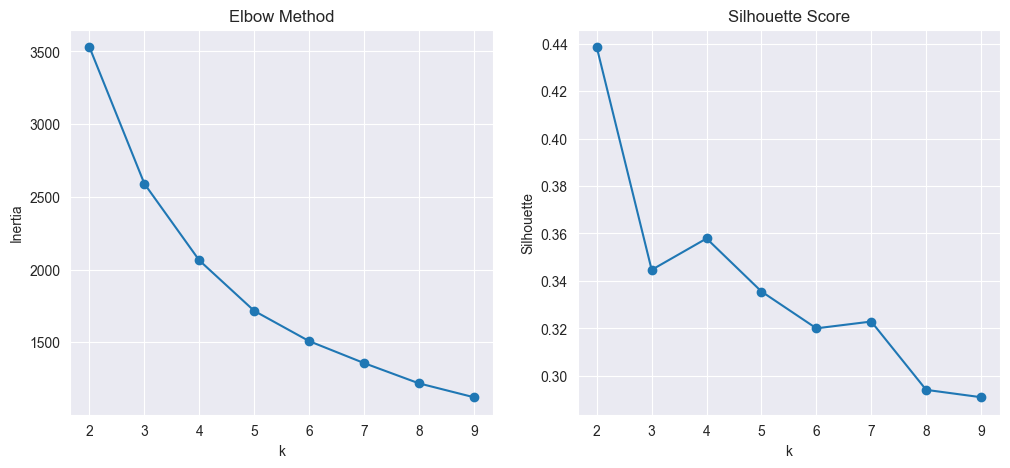

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.show()

From the elbow method and silhouette score we can choice k=4.

In [22]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(X)
rfm_df['Cluster'] = kmeans.labels_

In [23]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,CustomerLifespan,AvgGap,MedianGap,MaxGap,FavMonth,PctHighSeason,PctWeekend,Recency_score,Frequency_score,rf_segment,Cluster
0,12346.0,325,3,77352.96,321,122.250000,118.0,203.0,6,0.000000,0.000000,2,3,At-Risk,3
1,12347.0,1,8,4921.53,402,61.456044,53.0,90.0,10,0.391892,0.180180,5,4,Champions,3
2,12348.0,74,5,1658.40,362,77.814815,80.0,173.0,9,0.456522,0.043478,3,4,Loyal Customers,2
3,12349.0,18,3,3678.69,570,299.857143,389.0,389.0,11,0.732558,0.000000,5,3,Potential Loyalists,1
4,12350.0,309,1,294.40,0,714.000000,NaN,NaN,2,0.000000,0.000000,2,1,Hibernating,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848,18283.0,3,22,2658.95,654,33.327009,20.0,143.0,11,0.376068,0.105769,5,5,Champions,3
5849,18284.0,431,1,461.68,0,714.000000,NaN,NaN,10,1.000000,0.000000,1,2,Hibernating,0
5850,18285.0,660,1,427.00,0,714.000000,NaN,NaN,2,0.000000,0.000000,1,2,Hibernating,0
5851,18286.0,476,2,1296.43,247,247.000000,247.0,247.0,8,0.000000,0.000000,1,3,At-Risk,2


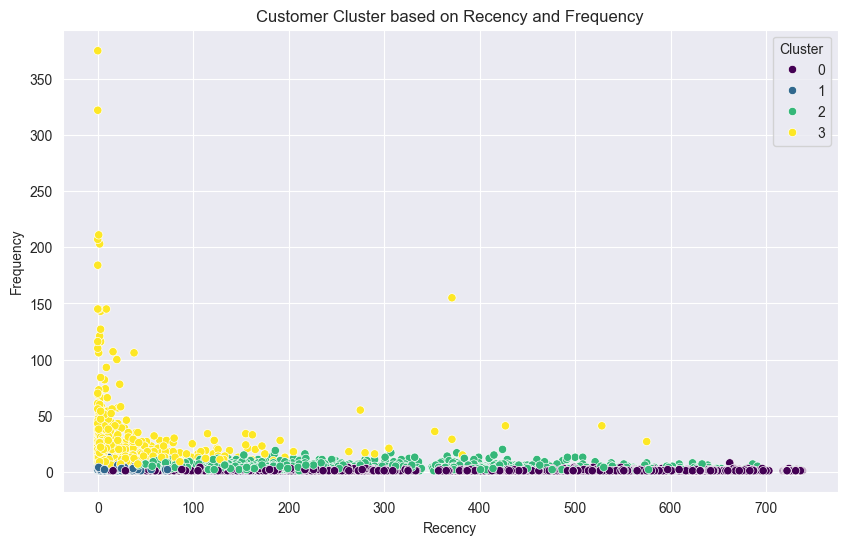

In [24]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Recency', y = 'Frequency', hue = 'Cluster', data = rfm_df, palette = 'viridis')
plt.title('Customer Cluster based on Recency and Frequency')
plt.show()

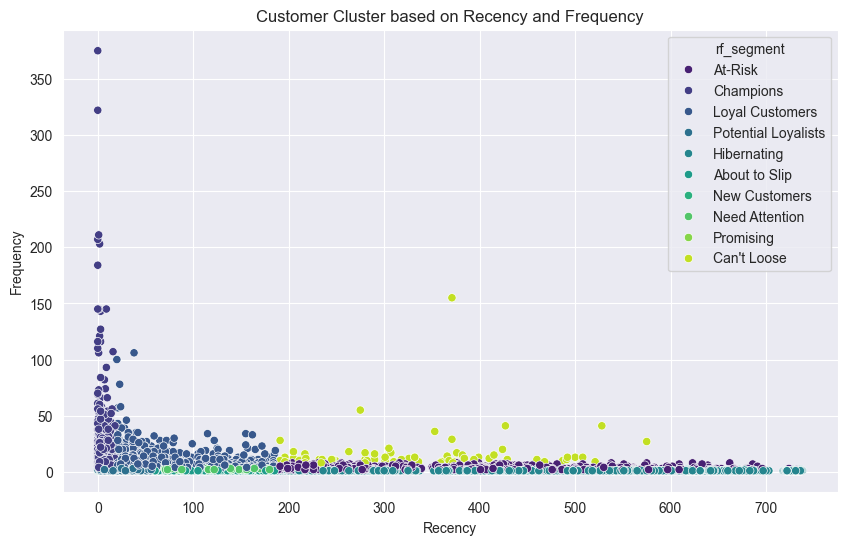

In [25]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Recency', y = 'Frequency', hue = 'rf_segment', data = rfm_df, palette = 'viridis')
plt.title('Customer Cluster based on Recency and Frequency')
plt.show()

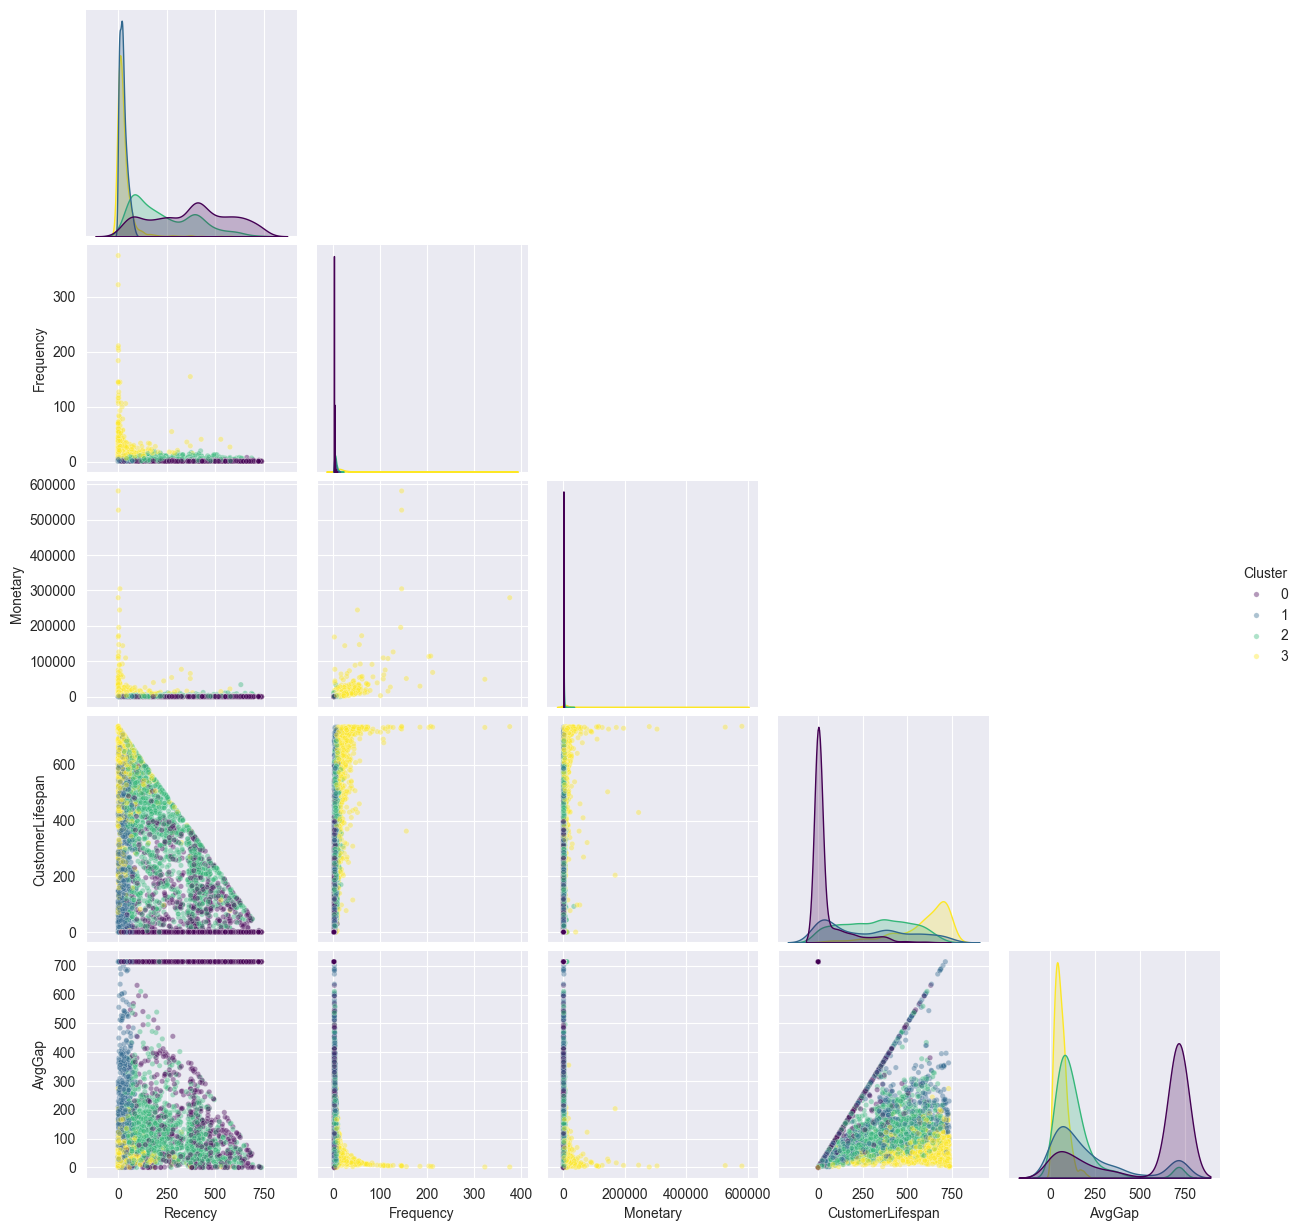

In [26]:
sns.pairplot(
    rfm_df,
    vars=['Recency', 'Frequency', 'Monetary', 'CustomerLifespan', 'AvgGap'],
    hue='Cluster',
    corner=True,
    plot_kws={'alpha': 0.4, 's': 15},
    palette = 'viridis'
)
plt.show()

In [27]:
rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()

,Recency,Frequency,Monetary
Cluster,,,
0,394.0,1.0,251.15
1,21.0,3.0,773.03
2,191.0,4.0,1346.51
3,16.0,13.0,5114.23


According to KMeans, we can conclude that we have 4 clusters with distinct characteristics:
- Cluster 0: clients with the lowest frequency and monetary values and high recency. These are one-shot customers who haven't returned recently. "Oneshot/Lost" segment.
- Cluster 1: customers with moderate monetary and low frequency and recency. We can say it's new customers who made a few purchases recently. "New/Early-stage" segment.
- Cluster 2: clients with high recency, moderate frequency and monetary. We can consider then as old good customers who used to purchase frequently but haven't returned recently. "At-Risk" segment.
- Cluster 3: customers with low recency, and high frequency and monetary. These are our best customers who purchase frequently and spend the most. "Champions/High-Value" segment.

<Axes: xlabel='Cluster'>

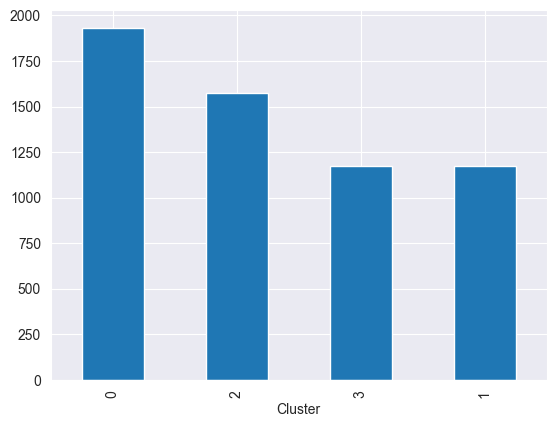

In [28]:
rfm_df['Cluster'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

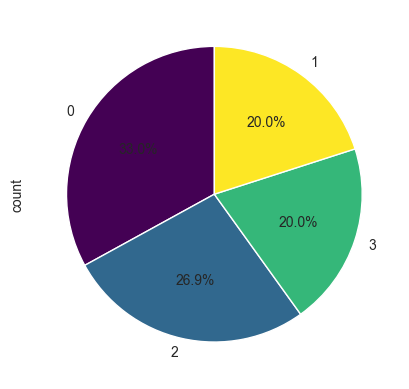

In [29]:
rfm_df['Cluster'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='viridis')

By observing the distribution of customers across clusters, we can say 60% of customers are one-shot/lost customers and at-risk customers. The remaining 40% stands for new/early-stage customers and champions/high-value customers.
So the marketing strategy is:
- For Cluster 0 (Oneshot/Lost): Implement win-back campaigns, offer special discounts or incentives to encourage repeat purchases.
- For Cluster 1 (New/Early-stage): Focus on onboarding and engagement strategies to build loyalty and encourage more frequent purchases.
- For Cluster 2 (At-Risk): Identify reasons for decreased engagement and implement targeted retention strategies, such as personalized offers or re-engagement campaigns.
- For Cluster 3 (Champions/High-Value): Reward loyalty with exclusive offers, early access to new products, or VIP programs to maintain their high level of engagement.